## Modeling_C model selection notebook

_In this notebook, the Modeling_\__C dataset is analyzed to create predictive models for the two output variables of interest_
***

First, the Modeling_C data is explored to provide numeric insights on the data to inform the design of the predictive models while ensuring that key model assumptions are met. Then, features are created for possible non-linear relationships. Finally, various models are tested for accuracy and a model is selected for each output variable (2) based on accuracy and interpretability.

### Data Exploration
***
#### Distribution

In [365]:
import pandas as pd
import numpy as np

Modeling_C = pd.read_csv("Modeling_C.csv")

Modeling_C.describe()

,X1,X2,X3,X4,Y1,Y2
count,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000,7056.000000
mean,16.344554,-6.638731,18.255549,-0.869205,0.305697,0.143991
std,23.108366,46.002759,18.853330,3.282870,0.460735,0.351105
min,-295.097310,-1021.432780,-182.753400,-61.294510,0.000000,0.000000
25%,13.929377,0.000000,15.509113,-0.775562,0.000000,0.000000
50%,22.831365,0.000000,23.497690,-0.404470,0.000000,0.000000
75%,27.117038,0.000000,27.573412,0.000000,1.000000,0.000000
max,466.049430,2.450000,478.932720,1.014770,1.000000,1.000000


With 7056 data points and binary output variables, the two model structures considered were binary logistic regression and support vector machines (SVM). With limited features, the creation of polynomial and interaction terms may help tease out important relationships between input variables that provide better predictions of the output.

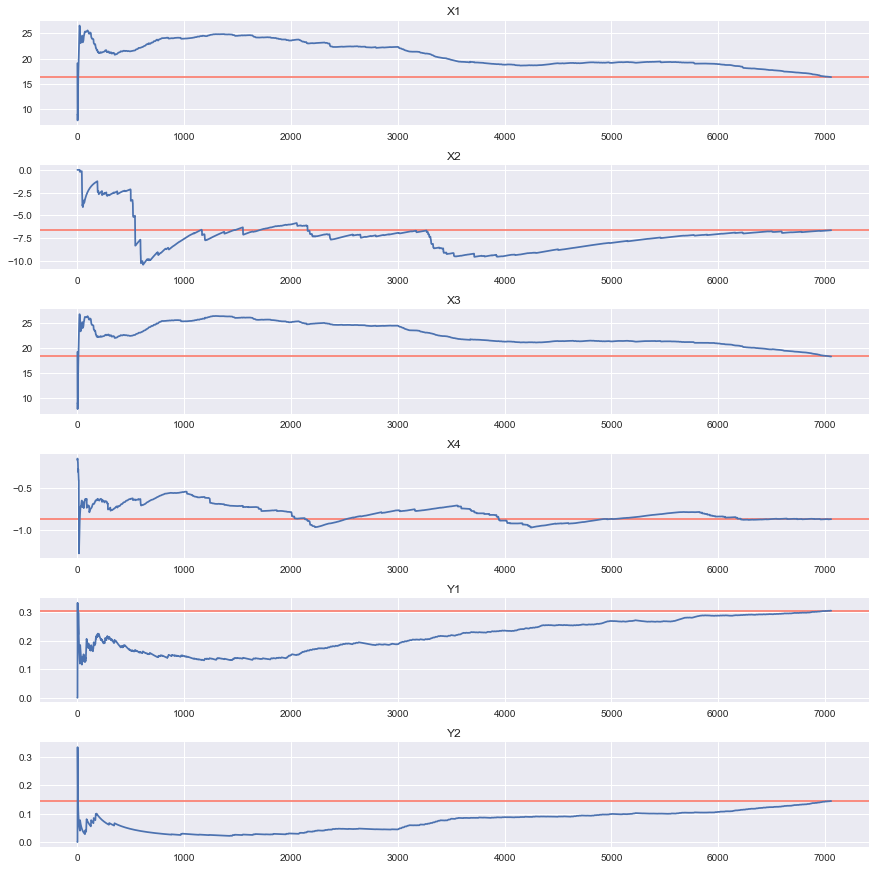

In [366]:
%matplotlib inline
import matplotlib.pyplot as plt 

Moving_Average = Modeling_C.cumsum()/range(1,7057)

fig, ax = plt.subplots(6, figsize = (12, 12))

plt_num = 0
for column in Moving_Average:
    ax[plt_num].axhline(Modeling_C[column].mean(), color = 'salmon')
    ax[plt_num].plot(range(1,7057), Moving_Average[column])
    ax[plt_num].set_title(column)
    plt_num += 1

plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 1.0)

The above graphs show the moving average (blue line) and the overall mean (red line), displaying a clear relationship between observation number and the X1, X3, Y1, and Y2 variables. This hints at a possible sequence dependence of the variables and challenges the assumption that each observation is independent. For the purposes of this model selection process, however, ordering effects are disregarded and the rows are randomly shuffled for further analyses.

In [328]:
from sklearn.utils import shuffle
Modeling_C = shuffle(Modeling_C)

X = Modeling_C[['X1','X2','X3','X4']] #input variables
Y1, Y2 = Modeling_C.Y1, Modeling_C.Y2 #output variables

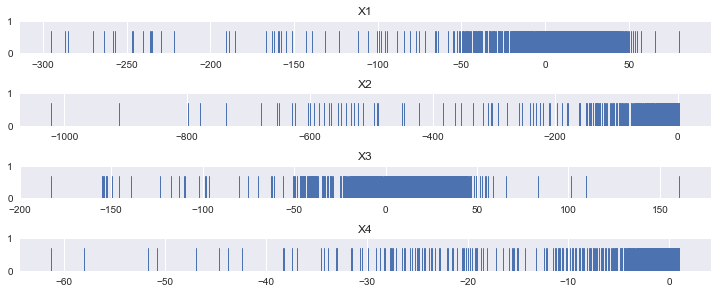

In [329]:
import seaborn as sns
fig, ax = plt.subplots(4, figsize = (10, 4))

plt_num = 0
for column in X:
    sns.rugplot(X[column], height = 0.7, ax = ax[plt_num]) #stacked rugplots for a quick view of distribution and range
    ax[plt_num].set_title(column)
    plt_num += 1
    
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 1.0)

Notable characteristics of these rugplots:
- All distributions appear negatively skewed
- The presence of a single extreme positive outlier in X1 and X3

In [2]:
X.skew()

X1    -3.980719
X2   -12.191428
X3    -0.605159
X4    -9.290534
dtype: float64

In [303]:
X[X.X1 > 400]

,X1,X2,X3,X4
3676,466.04943,0.0,478.93272,-26.79396


The X1 and X3 outliers occur within the same row of data, suggesting that the point may not be attributable to a simple data entry error. The outlier could indicate an extreme or rare event so the point is retained in the dataset especially given that the data are unlabeled. Models will be run with and without the outlier to determine how influential the outlier is to model coefficients and accuracy. _(The outlier was included as it was inconsequential to the model)_

In [4]:
X.X1.value_counts().head()

0.00000    56
0.00995    10
0.00998     9
0.01000     8
0.00994     8
Name: X1, dtype: int64

Count of most frequent X1 observations. All variables had a different top 5 for most frequent, but zero was always the most frequent observation despite not being the center of the overall distribution for X1 and X3. This is possibly an artifact of how the variables were measured or the samples are obtained from two or more distributions.

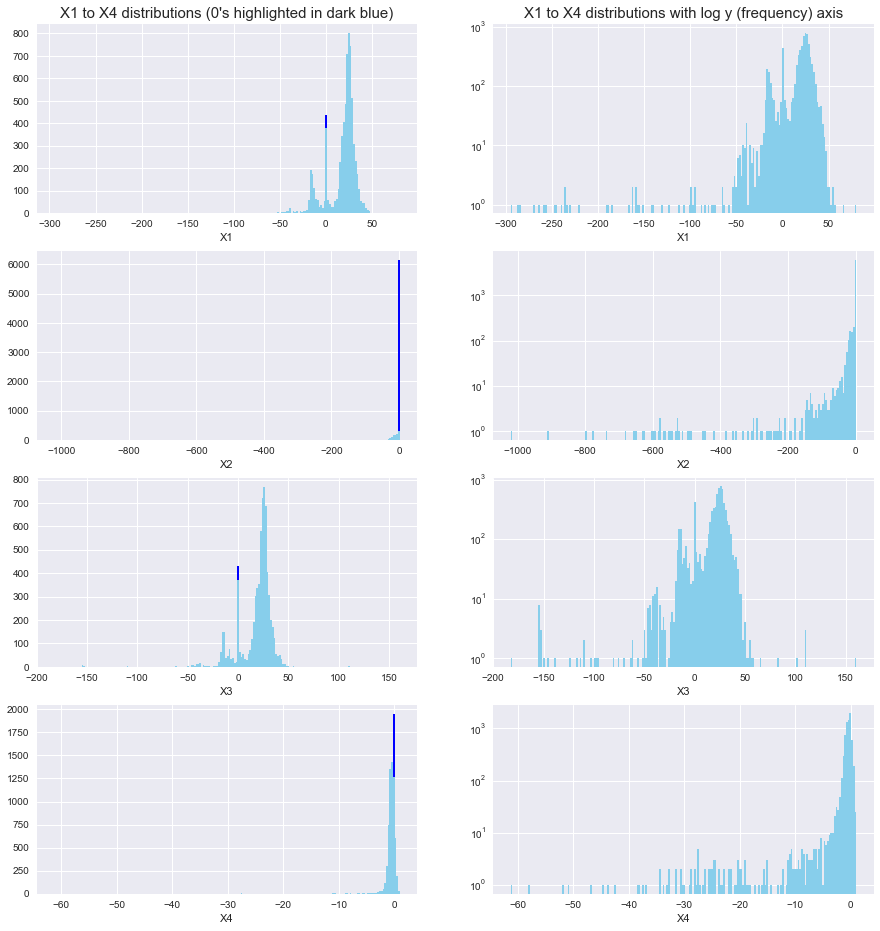

In [304]:
fig, ax = plt.subplots(ncols = 2, nrows = 4, figsize = (15, 16))

X_hist = X[X.X1 < 400] #remove the one outlier for plotting purposes

plt_num = 0
for column in X_hist:
    sns.distplot(X_hist[column], 
                 hist_kws = {'alpha': 1}, color = 'b', bins = 200, ax = ax[plt_num,0], kde = False)
    sns.distplot(X_hist[column][X_hist[column] != 0], 
                 hist_kws = {'alpha': 1}, color = 'skyblue', bins = 200, ax = ax[plt_num,0], kde = False)
    sns.distplot(X_hist[column], 
                 hist_kws = {'alpha': 1}, bins = 200, color = 'skyblue', ax = ax[plt_num,1], kde = False)
    ax[plt_num,1].set_yscale("log")
    plt_num += 1
    
ax[0,0].set_title("X1 to X4 distributions (0's highlighted in dark blue)",{'fontsize':15})
ax[0,1].set_title("X1 to X4 distributions with log y (frequency) axis",{'fontsize':15})

The above histograms visualize the input variable distributions with the most frequent observation, 0.0, highlighted in dark blue (left) and with a log y axis of frequency (right) providing a couple of insights:
- The distributions of X1 and X3 behave like a damped-wave with multimodality (4-7 local maxima).
- Even without observations at zero, a local frequency maxima would still occur near zero in X1, X2, and X3.
- The local maxima at zero appears to have a steeper peak than the other local maxima (perhaps standard deviation that scales with value).

#### Correlation

Given the primary model structure of interest is logistic regression, an important statistic to examine is correlation between input variables to avoid violating model assumptions for model coefficient interpretability. Below, the correlation matrix and pairplots are created:

In [7]:
Modeling_C.corr()

,X1,X2,X3,X4,Y1,Y2
X1,1.000000,0.199228,0.902343,0.015773,-0.423328,-0.512869
X2,0.199228,1.000000,0.036948,0.193020,-0.072488,-0.023997
X3,0.902343,0.036948,1.000000,-0.031520,-0.443240,-0.599424
X4,0.015773,0.193020,-0.031520,1.000000,-0.060284,-0.028311
Y1,-0.423328,-0.072488,-0.443240,-0.060284,1.000000,0.618098
Y2,-0.512869,-0.023997,-0.599424,-0.028311,0.618098,1.000000


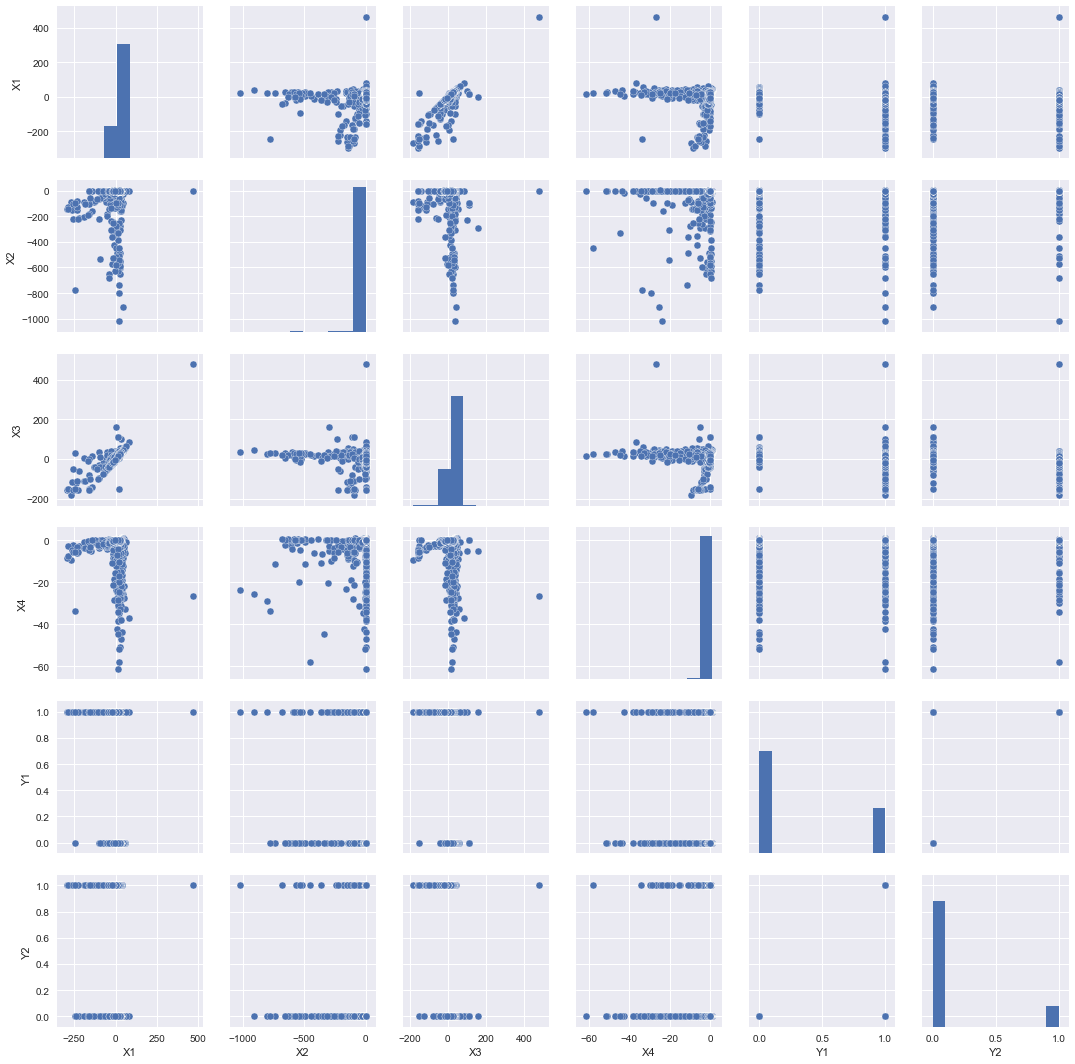

In [8]:
sns.pairplot(Modeling_C)

Some important insights from the correlation matrix and pairplots:
- The correlation between the X1 and X3 variables is the strongest at 0.90, meaning that these two variables should not be included in the same model for logistic regression in order to maintain interpretability of coefficients.
- Y1 and Y2 are treated as independent for this modeling exercise, but if they were dependent then the outcome _P(Y2 | ~Y1)_ equals zero given the sample.

### Feature Creation
***
With negative values, cubed root transformations are used. Features are also created on the interaction between cube root transformations and input variables.

In [330]:
from sklearn.preprocessing import PolynomialFeatures

from math import copysign
def cbrt(x):
    return copysign(abs(x)**(1/3), x)
cbrt = np.vectorize(cbrt)

X_cbrt = X.copy()

for column in X_cbrt.columns.values:
    X_cbrt['cbrt' + column] = cbrt(X_cbrt.loc[:,column])

cbrt_interaction = PolynomialFeatures(interaction_only = True, include_bias = False)

X_cbrt_interaction = cbrt_interaction.fit_transform(X_cbrt)
X_cbrt_interaction_names = np.array(cbrt_interaction.get_feature_names(X_cbrt.columns.values))

cbrt_idxlist = []
for idx, name in enumerate(X_cbrt_interaction_names):
    if 'cbrt' in name:
        cbrt_idxlist.append(idx)
        #index of cubed root features to avoid overlap

3rd degree polynomial features and interactions are created to further address possible non-linear relationships in the data.

In [331]:
poly3 = PolynomialFeatures(3) #create polynomial and interaction features with data

X_poly = poly3.fit_transform(X)
X_poly_names = np.array(poly3.get_feature_names(['X1','X2','X3','X4']))

feature_names = np.append(X_poly_names, X_cbrt_interaction_names[cbrt_idxlist])

X_features = np.concatenate((X_poly, X_cbrt_interaction[:,cbrt_idxlist]), axis = 1)

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
X_features = standard_scaler.fit_transform(X_features)

X_m = pd.DataFrame(X_features, columns = feature_names)

### Model Selection
***
#### Y1 Logistic Models

In [368]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

LR_model = LogisticRegression()

LR_model_cv = pd.DataFrame({"Model_Parameters" : [['X1','X2','X4'],
                                                  ['X1','X4'],
                                                  ['X4'],
                                                  ['X2'],
                                                  ['X3','X3 X4','X4'],
                                                  ['X3','X3^2','X4'],
                                                  ['X3','X4'],
                                                  ['X1'],
                                                  ['X3'],
                                                  ['X3','cbrtX4'],
                                                  ['X1','cbrtX4'],
                                                  ['cbrtX3','X3','X3^2','X3^3','X4','X3 X4'],
                                                  ['cbrtX1','X1','X1^2','X1^3','X4','X1 X4'],
                                                  list(feature_names)
                                      ]})

LR_model_cv['Average_cv_accuracy'] = ""
for i in range(1,11):
    LR_model_cv['cv'+ str(i)] = ""

for idx,model in enumerate(LR_model_cv.Model_Parameters):
    cv_scores = cross_val_score(LR_model, X_m[model], Y1, cv=10)
    LR_model_cv.loc[idx,'cv1':'cv10'] = cv_scores
    LR_model_cv.Average_cv_accuracy[idx] = np.average(cv_scores)

LR_model_cv

,Model_Parameters,Average_cv_accuracy,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,cv10
0,"[X1, X2, X4]",0.805527,0.815864,0.796034,0.813031,0.796034,0.808782,0.808782,0.792908,0.798582,0.821277,0.803977
1,"[X1, X4]",0.805953,0.815864,0.798867,0.813031,0.794618,0.808782,0.808782,0.794326,0.798582,0.821277,0.805398
2,[X4],0.692703,0.691218,0.686969,0.692635,0.694051,0.691218,0.686969,0.696454,0.699291,0.692199,0.696023
3,[X2],0.693693,0.691218,0.694051,0.695467,0.695467,0.686969,0.692635,0.696454,0.696454,0.697872,0.690341
4,"[X3, X3 X4, X4]",0.805103,0.813031,0.8017,0.803116,0.805949,0.803116,0.8017,0.801418,0.8,0.815603,0.805398
5,"[X3, X3^2, X4]",0.804678,0.804533,0.798867,0.804533,0.810198,0.803116,0.804533,0.8,0.8,0.812766,0.808239
6,"[X3, X4]",0.806096,0.808782,0.8017,0.807365,0.807365,0.803116,0.803116,0.802837,0.804255,0.815603,0.806818
7,[X1],0.805526,0.814448,0.803116,0.814448,0.794618,0.808782,0.811615,0.788652,0.794326,0.822695,0.802557
8,[X3],0.805951,0.813031,0.805949,0.804533,0.807365,0.805949,0.808782,0.797163,0.798582,0.815603,0.802557
9,"[X3, cbrtX4]",0.80822,0.815864,0.803116,0.807365,0.808782,0.804533,0.811615,0.805674,0.802837,0.817021,0.805398


Across the 14 tested models, there was high accuracy (~80%) and low variability in the cross validation scores for models that included X1 or X3 as parameters.

#### Y1 Support Vector Classifiers

In [344]:
from sklearn.svm import SVC

SVC_model_cv = pd.DataFrame({"SVC_kernel" : ['rbf',
                                             'linear',
                                             'sigmoid',
                                             'poly']})

SVC_model_cv['Average_cv_accuracy'] = ""

for i in range(1,11):
    SVC_model_cv['cv'+ str(i)] = ""

for idx,kernel in enumerate(SVC_model_cv.SVC_kernel):
    SVC_model = SVC(kernel = kernel)
    cv_scores = cross_val_score(SVC_model, X_m, Y1, cv=10)
    SVC_model_cv.loc[idx,'cv1':'cv10'] = cv_scores
    SVC_model_cv.Average_cv_accuracy[idx] = np.average(cv_scores)

SVC_model_cv

,SVC_kernel,Average_cv_accuracy,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,cv10
0,rbf,0.823671,0.834278,0.818697,0.825779,0.813031,0.82153,0.831445,0.817021,0.814184,0.838298,0.822443
1,linear,0.821829,0.827195,0.81728,0.822946,0.807365,0.822946,0.831445,0.811348,0.815603,0.836879,0.825284
2,sigmoid,0.773776,0.774788,0.77762,0.773371,0.763456,0.764873,0.791785,0.777305,0.757447,0.788652,0.768466
3,poly,0.814175,0.82153,0.81728,0.815864,0.800283,0.813031,0.818697,0.808511,0.8,0.828369,0.818182


The rbf kernel resulted in the most accurate classifier of all models tested. This model was not selected, however, as it is non probabilistic and provides fewer insights on the effects of each input variable on the outcome.

#### Y1 Selected Model

In [371]:
LR_model.fit(X_m[['X1','cbrtX4']], Y1)
print("Y1 Model Selected: logit(Y1) = %.3f + (%.3f) * X1 + (%.3f) * X4 ^ (1/3)" 
      % (LR_model.intercept_,LR_model.coef_[0][0],LR_model.coef_[0][1]))

Y1 Model Selected: logit(Y1) = -0.899 + (-1.717) * X1 + (-0.225) * X4 ^ (1/3)


The selected model for Y1 was a logistic regression with X1 and the cubed root of X4 as it was both simple and accurate (81.2% accuracy). For pure accuracy, the support vector classifier with a rbf kernel could produce the best results of the models tested (~1.2% increase in accuracy over the chosen model).

In [373]:
y1_cm = confusion_matrix(Y1,LR_model.predict(X_m[['X1','cbrtX4']]))
y1_cm = pd.DataFrame(y1_cm,columns=["0","1"],index=["0","1"])
print("Confusion matrix of chosen model (rows are actual and columns are predicted)")
y1_cm

Confusion matrix of chosen model (rows are actual and columns are predicted)


,0,1
0,4567,332
1,998,1158


A quick look at the false positive and false negative rates of the selected model show that the model has a relatively high false negative (Type II error) rate, which may be relevant depending on usage of the chosen model.

#### Y2 Logistic Models

In [369]:
for idx,model in enumerate(LR_model_cv.Model_Parameters):
    cv_scores = cross_val_score(LR_model, X_m[model], Y2, cv=10)
    LR_model_cv.loc[idx,'cv1':'cv10'] = cv_scores
    LR_model_cv.Average_cv_accuracy[idx] = np.average(cv_scores)

LR_model_cv

,Model_Parameters,Average_cv_accuracy,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,cv10
0,"[X1, X2, X4]",0.918634,0.934844,0.933428,0.932011,0.913598,0.916431,0.926241,0.899291,0.906383,0.899291,0.924823
1,"[X1, X4]",0.910272,0.926346,0.929178,0.910765,0.905099,0.907932,0.920567,0.899291,0.899291,0.893617,0.910638
2,[X4],0.856131,0.855524,0.855524,0.855524,0.855524,0.855524,0.856738,0.856738,0.856738,0.856738,0.856738
3,[X2],0.856131,0.855524,0.855524,0.855524,0.855524,0.855524,0.856738,0.856738,0.856738,0.856738,0.856738
4,"[X3, X3 X4, X4]",0.931818,0.947592,0.939093,0.949008,0.923513,0.926346,0.93617,0.916312,0.92766,0.91773,0.934752
5,"[X3, X3^2, X4]",0.932667,0.949008,0.94051,0.951841,0.926346,0.927762,0.93617,0.916312,0.926241,0.91773,0.934752
6,"[X3, X4]",0.932384,0.947592,0.939093,0.950425,0.924929,0.927762,0.93617,0.916312,0.92766,0.919149,0.934752
7,[X1],0.910414,0.924929,0.929178,0.909348,0.905099,0.909348,0.920567,0.897872,0.900709,0.895035,0.912057
8,[X3],0.932243,0.947592,0.939093,0.949008,0.923513,0.926346,0.93617,0.916312,0.92766,0.921986,0.934752
9,"[X3, cbrtX4]",0.932385,0.949008,0.937677,0.949008,0.926346,0.926346,0.93617,0.916312,0.929078,0.91773,0.93617


X1 and X3 provide the strongest predictors of the output variable Y2 with low variability and high accuracy (~92%) between cross validation scores.

#### Y2 Support Vector Classifiers

In [346]:
for idx,kernel in enumerate(SVC_model_cv.SVC_kernel):
    SVC_model = SVC(kernel = kernel)
    cv_scores = cross_val_score(SVC_model, X_m, Y2, cv=10)
    SVC_model_cv.loc[idx,'cv1':'cv10'] = cv_scores
    SVC_model_cv.Average_cv_accuracy[idx] = np.average(cv_scores)

SVC_model_cv

,SVC_kernel,Average_cv_accuracy,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,cv10
0,rbf,0.930541,0.943343,0.939093,0.950425,0.924929,0.929178,0.933333,0.914894,0.920567,0.91773,0.931915
1,linear,0.931959,0.943343,0.937677,0.951841,0.924929,0.930595,0.939007,0.914894,0.926241,0.91773,0.933333
2,sigmoid,0.91594,0.934844,0.923513,0.932011,0.916431,0.913598,0.906383,0.900709,0.910638,0.90922,0.912057
3,poly,0.930116,0.946176,0.934844,0.950425,0.922096,0.926346,0.930496,0.914894,0.92766,0.91773,0.930496


The linear kernel produced the highest predictive accuracy for the tested support vector classifiers, but the logistic models remain better for predictive accuracy and also provide probabilistic outputs for further interpretation.

#### Y2 Selected Model

In [352]:
LR_model.fit(X_m[['X3']], Y2)
print("Y2 Model Selected: logit(Y2) = %.3f + (%.3f) * X3" 
      % (LR_model.intercept_,LR_model.coef_[0][0]))

Y2 Model Selected: logit(Y2) = -2.851 + (-2.420) * X3


The selected model for Y2 was a logistic regression with X3 for simplicity and accuracy (93.2% accuracy). For pure accuracy, the logistic regression with all features included could produce the best results of the models tested (~0.5% increase in accuracy over the chosen model).

In [353]:
y2_cm = confusion_matrix(Y2,LR_model.predict(X_m[['X3']]))
y2_cm = pd.DataFrame(y2_cm,columns=["0","1"],index=["0","1"])
print("Confusion matrix of chosen model (rows are actual and columns are predicted)")
y2_cm

Confusion matrix of chosen model (rows are actual and columns are predicted)


,0,1
0,5929,111
1,367,648


Albeit better than the Y1 model in terms of false negatives, a relatively high rate of Type II error is a drawback of the Y2 model as well. Likely due to an imbalanced dataset.

### Conclusion

From the various models tested, it appears as though both output variables are best predicted with a logistic regression. The unlabeled nature of the variables explored adds some obscurity to significance of distributional information and the relative impact of different types of incorrect predictions (Type I versus Type II errors). For the purposes of this exercise, accuracy and interpretability of model coefficients were chosen as the two most important elements during model selection.